In [1]:

NUM_PROC_MAP = 150 # expect 30 min with single process
PUSH_TO_HF = False

DEBUG = True
EPOCHS = 10
HF_USERNAME = None

import os

from dotenv import load_dotenv
load_dotenv()
import datasets
from datasets import DatasetDict
from datasets import load_dataset
import datasets
import torch
import json
from huggingface_hub import HfApi

import numpy as np

from scipy.stats import norm
from scipy.stats import f
from scipy.stats import lognorm
import plotting
import matplotlib.pyplot as plt
import json
import os
import pandas as pd
import torch
import datasets
from datasets import load_dataset




DEBUG = True

import torch
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


from baseline_curricula import validate_training_duration_limitation
from itertools import product, chain
import config 
from util import get_curriculum

jobs =[(dataset, curriculum,model_type) for dataset, model_type, curriculum in product(config.datasets, config.model_types, config.baseline_curricula)]
jobs.extend([(dataset, model_type + curriculum,model_type) for dataset, model_type, curriculum  in (product(config.datasets, config.model_types, config.influence_curricula))])


In [2]:
from util import get_curriculum


In [3]:

from itertools import product
import config 

In [ ]:
import os
import torch
import pandas as pd
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
word_count = lambda d: {"words": len(d["text"].split())}
cache_path = (os.path.join("./plotting_notebooks/cache/","curricula_metrics.csv"))


def count_tokens_seen(word_counts_dataset, curriculum):
    indices = torch.cat(curriculum).flatten().tolist()
    selected = word_counts_dataset.select(indices)
    return sum(selected["words"])

if not os.path.exists(cache_path):
    dataset_cache = {}
    unique_datasets = set(dataset for dataset, _,_ in jobs)

    # Preprocess and cache each dataset once
    for dataset_name in tqdm(unique_datasets, desc="Preprocessing datasets"):
        dataset = load_dataset(dataset_name)["train"]
        word_counts_dataset = dataset.map(word_count, num_proc=100)
        dataset_cache[dataset_name] = {
            "word_counts": word_counts_dataset,
            "tokens_in_dataset": sum(word_counts_dataset["words"]),
            "dataset_len": len(dataset),
        }

    def process_experiment(args):
        dataset_name, curriculum_name, model_type,  data_info = args
        curriculum = get_curriculum(dataset_name, curriculum_name)
        
        r = {
            "dataset": dataset_name,
            "model_type": model_type,
            "curriculum": curriculum_name,
            "documents in dataset": data_info["dataset_len"],
            "documents seen by model": sum(len(epoch) for epoch in curriculum),
            "tokens in dataset": data_info["tokens_in_dataset"],
            "tokens seen by model": count_tokens_seen(data_info["word_counts"], curriculum),
        }
        # print( r, flush=True)
        return r

    job_args = [(dataset, curriculum, model_type, dataset_cache[dataset]) for dataset, curriculum, model_type in jobs]

    with Pool(10) as pool:
        results = list(tqdm(pool.imap(process_experiment, job_args), total=len(job_args)))

    df = pd.DataFrame(results)
    df.to_pickle(cache_path)

else:
    print("Reusing cached results")

df = pd.read_pickle(cache_path)


In [5]:
# df = df.set_index(["dataset","curriculum"])

In [6]:
import torch
import numpy as np
from scipy.stats import spearmanr
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

def process_job(d):
    dataset_name, curriculum_name, model_type = d
    curriculum = get_curriculum(dataset_name,curriculum_name)
    return (d, torch.cat(curriculum).flatten())

# Process jobs with threads
data = []
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_job, d) for d in jobs]
    for future in tqdm(as_completed(futures), total=len(jobs), desc="Processing jobs"):
        data.append(future.result())

# Truncate tensors
tensors = [item[1] for item in data]
file_names = [item[0] for item in data]
min_length = min(tensor.shape[0] for tensor in tensors)
truncated_tensors = [tensor[:min_length] for tensor in tensors]

# Compute correlation
def compute_corr(i, j):
    corr, _ = spearmanr(truncated_tensors[i].numpy(), truncated_tensors[j].numpy(), alternative="two-sided")
  #  print("(i, j, corr)",(i, j, corr),flush=True)
    return (i, j, corr)

n = len(truncated_tensors)
pairs = [(i, j) for i in range(n) for j in range(i, n)]

# Run correlation computations with threads
results = []
with ThreadPoolExecutor(max_workers=64) as executor:
    results = list(tqdm(executor.map(lambda pair: compute_corr(pair[0], pair[1]), pairs), total=len(pairs), desc="Computing correlations"))

# Assemble matrix
corr_matrix = np.zeros((n, n))
for i, j, corr in results:
    corr_matrix[i, j] = corr
    if i != j:
        corr_matrix[j, i] = corr


Processing jobs:   0%|          | 0/78 [00:00<?, ?it/s]

Computing correlations: 100%|██████████| 3081/3081 [00:36<00:00, 84.35it/s] 


In [7]:
multi_index = pd.MultiIndex.from_tuples(file_names, names=['dataset', 'curriculum',"model_type"])

corr_df = pd.DataFrame(corr_matrix, index=multi_index, columns=multi_index)

corr_df

dataset                                                                                      loris3/stratified_equitoken_10m_curriculum  \
curriculum                                                                                                     perplexity_increasing.pt   
model_type                                                                                                                        llama   
dataset                                    curriculum                             model_type                                              
loris3/stratified_equitoken_10m_curriculum perplexity_increasing.pt               llama                                        1.000000   
                                           random.pt                              llama                                       -0.001197   
                                           source_difficulty.pt                   roberta                                      0.000501   
                                           mattr_increasing.pt                    roberta                                      0.141305   
                                           random.pt                              roberta                                     -0.001197   
...                                                                                                                                 ...   
loris3/stratified_10m_curriculum           roberta_influence_epoch_repetition.pt  roberta                                     -0.000411   
                                           roberta_influence_incr_bins_dirac.pt   roberta                                     -0.010731   
                                           roberta_influence_decr_bins_lognorm.pt roberta                                      0.008411   
                                           roberta_influence_tracin_sandwich.pt   roberta                                      0.012389   
                                           roberta_influence_decr_cp_dirac.pt     roberta                                      0.006196   

dataset                                                                                                 \
curriculum                                                                                   random.pt   
model_type                                                                                       llama   
dataset                                    curriculum                             model_type             
loris3/stratified_equitoken_10m_curriculum perplexity_increasing.pt               llama      -0.001197   
                                           random.pt                              llama       1.000000   
                                           source_difficulty.pt                   roberta     0.000190   
                                           mattr_increasing.pt                    roberta    -0.000348   
                                           random.pt                              roberta     1.000000   
...                                                                                                ...   
loris3/stratified_10m_curriculum           roberta_influence_epoch_repetition.pt  roberta     0.000239   
                                           roberta_influence_incr_bins_dirac.pt   roberta     0.000628   
                                           roberta_influence_decr_bins_lognorm.pt roberta    -0.000967   
                                           roberta_influence_tracin_sandwich.pt   roberta     0.001117   
                                           roberta_influence_decr_cp_dirac.pt     roberta     0.000511   

dataset                                                                                                            \
curriculum                                                                                   source_difficulty.pt   
model_type                                                                               

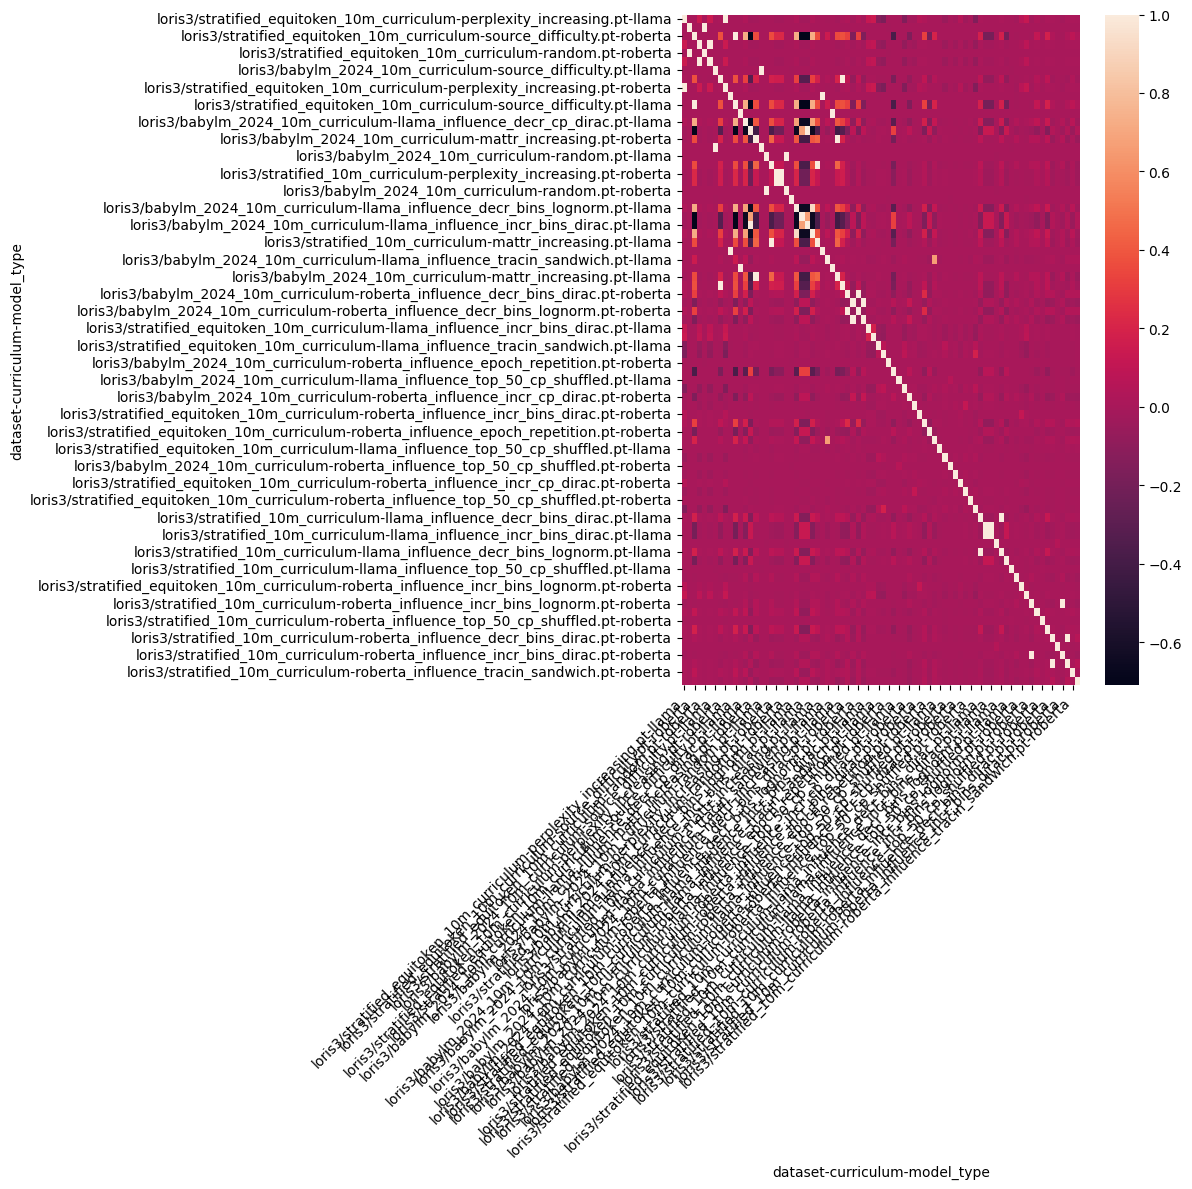

In [8]:

plt.figure(figsize=(12, 12))
sns.heatmap(corr_df, annot=False, cbar=True)

plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0)  
plt.tight_layout()  
plt.show()


In [9]:
import util

In [10]:
corr_df = corr_df.sort_index(level=1, ascending=True,key=lambda x: x.map(util.rename))
corr_df = corr_df.sort_index(level='curriculum', axis=1, ascending=True, key=lambda x: x.map(util.rename))

- How similar are the influence curricula to the baselines?


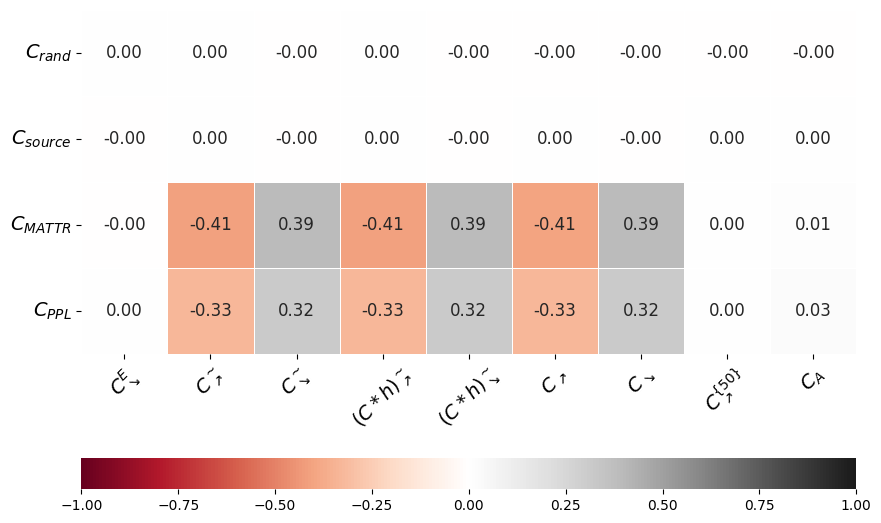

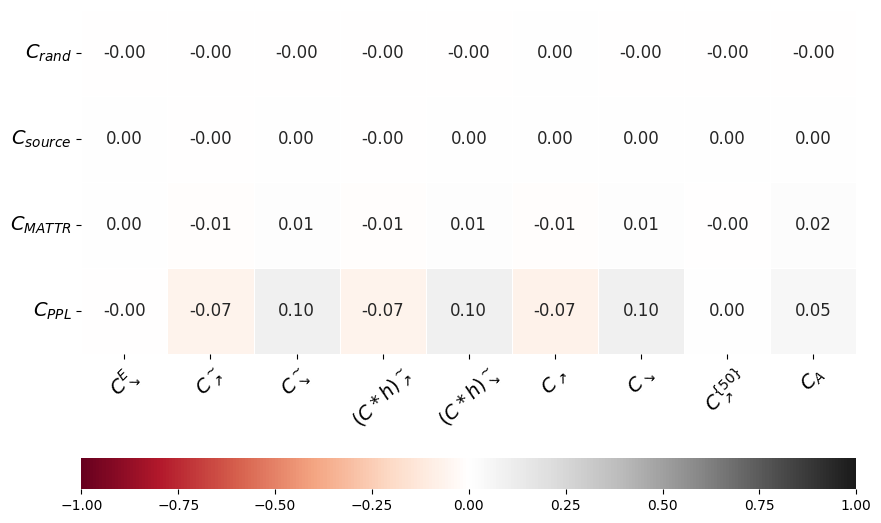

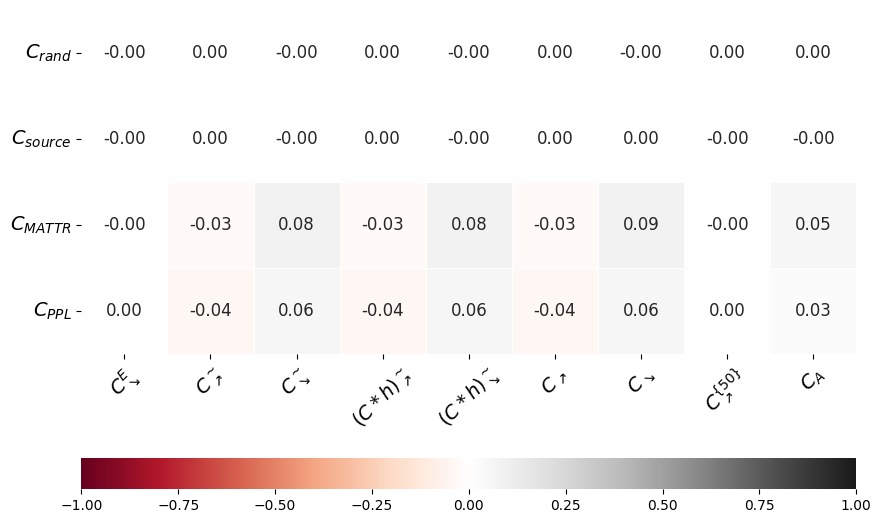

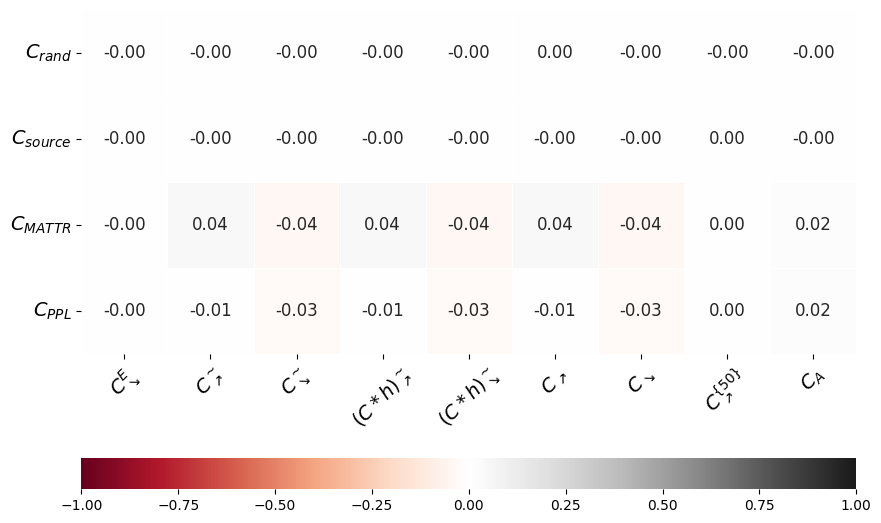

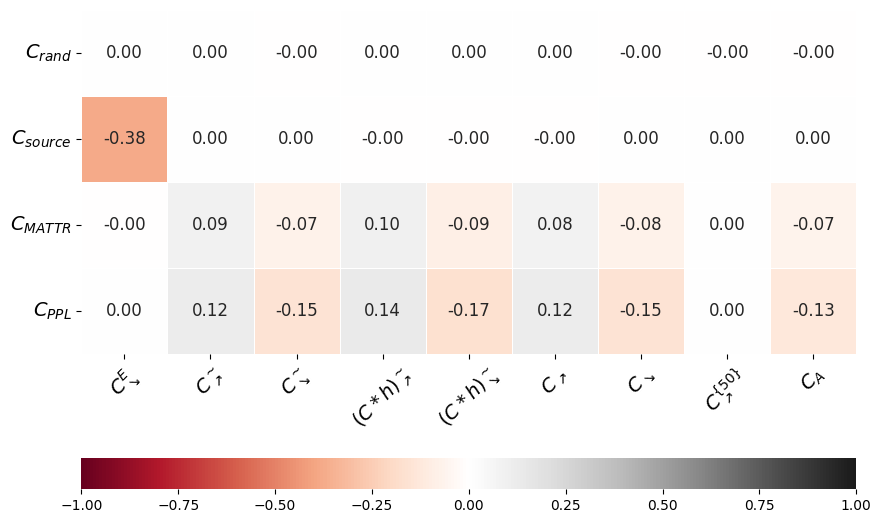

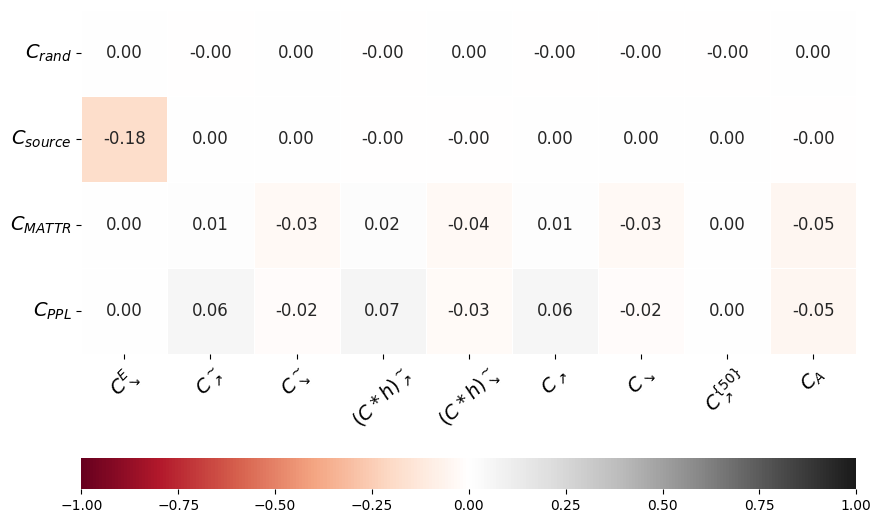

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

unique_datasets = corr_df.index.get_level_values('dataset').unique()
unique_model_types = corr_df.index.get_level_values('model_type').unique()

for dataset in unique_datasets:
    for model_type in unique_model_types:
        dataset_corr = corr_df.loc[
            (dataset, config.baseline_curricula, model_type),
            (dataset, [model_type + c for c in config.influence_curricula], model_type)
        ]

        fig = plt.figure(figsize=(10, 8))
        gs = gridspec.GridSpec(2, 1, height_ratios=[20, 1], hspace=-0.10)
        ax = fig.add_subplot(gs[0])
        cbar_ax = fig.add_subplot(gs[1])

        sns.heatmap(
            dataset_corr,
            ax=ax,
            cbar_ax=cbar_ax,
            annot=True,
            cmap='RdGy',
            fmt='.2f',
            cbar_kws={'orientation': 'horizontal'},
            linewidths=0.5,
            annot_kws={'size': 12},
            vmin=-1,
            vmax=1
        )

        ax.set_yticklabels(
            [util.rename(i) for i in dataset_corr.index.get_level_values(1).unique()],
            rotation=0,
            fontsize=14
        )
        ax.set_xticklabels(
            [util.rename(i) for i in dataset_corr.columns.get_level_values(1).unique()],
            rotation=45,
            fontsize=14
        )


        plt.xlabel("", fontsize=14)
        plt.ylabel("", fontsize=14)
        ax.set_aspect('equal', adjustable='box')
        ax.set_xlabel("")
        ax.set_ylabel("")
        save_path = os.path.join("./autogenerated_figures", "spearmans_rho", dataset, model_type + ".pdf")
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        

        plt.savefig(save_path, dpi=600, bbox_inches='tight')
        plt.show()


- How similar are the influence curricula across model types?


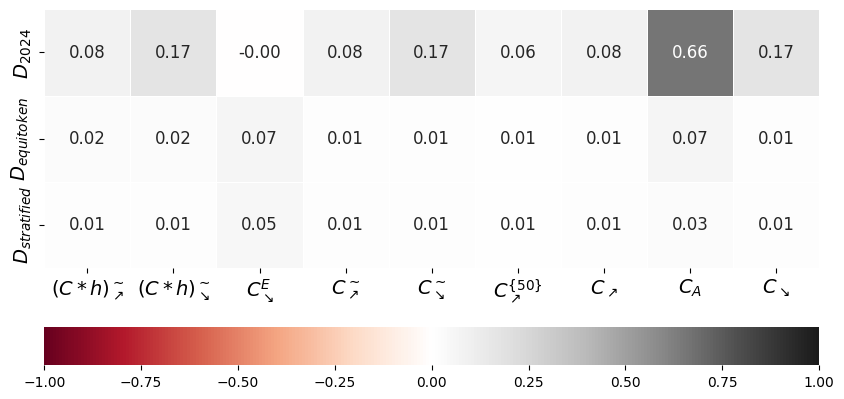

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

data = []
for model_type in config.model_types:
    for dataset in config.datasets:
        for curriculum in config.influence_curricula:
            corr = corr_df.loc[(dataset, "llama"+curriculum, "llama"), (dataset, "roberta"+curriculum, "roberta")]
            data.append({
                'dataset': util.rename_dataset(dataset),
                'curriculum': util.rename(curriculum),
                'corr' : corr
            })

c = pd.DataFrame(data)

heatmap_data = c.pivot_table(index='dataset', columns='curriculum', values='corr')

plt.figure(figsize=(10, 8))

sns.heatmap(
    heatmap_data, 
    annot=True, 
    cmap='RdGy', 
    fmt='.2f', 
    cbar_kws={'label': '', 'orientation': 'horizontal'}, 
    linewidths=0.5, vmin=-1, vmax=1,
    annot_kws={'size': 12} 
)


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("", fontsize=14)
plt.ylabel("", fontsize=14)


plt.gca().set_aspect('equal', adjustable='box')


plt.subplots_adjust(top=0.6)


save_path = os.path.join("./autogenerated_figures", "spearmans_rho_inter_model_type.pdf")
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, dpi=600, bbox_inches='tight')
plt.show()
